In [1]:
# 导入相关包
import os
import time
import random
import jieba as jb
import numpy as np
import jieba.analyse
import tensorflow as tf
import tensorflow.keras as K
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical


读取数据集，保存在字典中

In [2]:
dataset = {}
path = "./dataset/"
files= os.listdir(path)
for file in files:
    if not os.path.isdir(file) and not file[0] == '.': # 跳过隐藏文件和文件夹
        f = open(path+"/"+file, 'r',  encoding='UTF-8'); # 打开文件
        for line in f.readlines():
            dataset[line] = file[:-4]


数据集总共有 8438 个文本片段，现在展示其中的 10 个片段及其作者。

In [4]:
name_zh = {'LX': '鲁迅', 'MY':'莫言' , 'QZS':'钱钟书' ,'WXB':'王小波' ,'ZAL':'张爱玲'} 
for (k,v) in  list(dataset.items())[:1]:
    print(k,'---',name_zh[v])

几个少年辛苦奔走了十多年，暗地里一颗弹丸要了他的性命；几个少年一击不中，在监牢里身受一个多月的苦刑；几个少年怀着远志，忽然踪影全无，连尸首也不知那里去了。——“他们都在社会的冷笑恶骂迫害倾陷里过了一生；现在他们的坟墓也早在忘却里渐渐平塌下去了。
 --- 鲁迅


## 2.2 数据集预处理  
在做文本挖掘的时候，首先要做的预处理就是分词。  
英文单词天然有空格隔开容易按照空格分词，但是也有时候需要把多个单词做为一个分词，比如一些名词如 "New York" ，需要做为一个词看待。  
而中文由于没有空格，分词就是一个需要专门去解决的问题了。  
这里我们使用 jieba 包进行分词，使用**精确模式**、**全模式**和**搜索引擎模式**进行分词对比。  
更多方法参考：https://github.com/fxsjy/jieba   

In [ ]:
# 精确模式分词
titles = [".".join(jb.cut(t, cut_all=False)) for t,_ in dataset.items()]
print("精确模式分词结果:\n",titles[0])

In [ ]:
# 全模式分词
titles = [".".join(jb.cut(t, cut_all=True)) for t,_ in dataset.items()]
print("全模式分词结果:\n",titles[0])

In [ ]:
# 搜索引擎模式分词
titles = [".".join(jb.cut_for_search(t)) for t,_ in dataset.items()]
print("搜索引擎模式分词结果:\n",titles[0])

### 使用 TF-IDF 算法统计各个作品的关键词频率
TF-IDF（term frequency–inverse document frequency，词频-逆向文件频率）是一种用于信息检索与文本挖掘的常用加权技术。  
* TF-IDF是一种统计方法，用以评估一字词对于一个文件集或一个语料库中的其中一份文件的重要程度。字词的重要性随着它在文件中出现的次数成正比增加，但同时会随着它在语料库中出现的频率成反比下降。  
* TF-IDF的主要思想是：如果某个单词在一篇文章中出现的频率TF高，并且在其他文章中很少出现，则认为此词或者短语具有很好的类别区分能力，适合用来分类。  
这里我们使用 jieba 中的默认语料库来进行关键词抽取，并展示每位作者前 5 个关键词


In [ ]:
import jieba.analyse
# 将片段进行词频统计
str_full = {}
str_full['LX'] = ""
str_full['MY'] = ""
str_full['QZS'] = ""
str_full['WXB'] = ""
str_full['ZAL'] = ""

for (k,v) in dataset.items():
    str_full[v] += k

for (k,v) in str_full.items():
    print(k,":")
    for x, w in jb.analyse.extract_tags(v, topK=5, withWeight=True):
        print('%s %s' % (x, w))

## 2.3 采用 Keras 建立一个简单的深度神经网络模型
通过 Keras 构建深度学习模型的步骤如下：
+ 定义模型——创建一个模型并添加配置层
+ 编译模型——指定损失函数和优化器，并调用模型的 compile() 函数，完成模型编译。
+ 训练模型——通过调用模型的 fit() 函数来训练模型。
+ 模型预测——调用模型的 evaluate()或者 predict() 等函数对新数据进行预测。

### 2.3.1 读取数据集
首先需要读取数据集，记录每个片段的作者并保存。

In [5]:
# 读取数据和标签
def load_data(path):
    """
    :param path:数据集文件夹路径
    :return:返回读取的片段和对应的标签
    """
    sentences = [] # 片段
    target = [] # 作者
    
    # 定义lebel到数字的映射关系
    labels = {'LX': 0, 'MY': 1, 'QZS': 2, 'WXB': 3, 'ZAL': 4}

    files = os.listdir(path)
    for file in files:
        if not os.path.isdir(file):
            f = open(path + "/" + file, 'r', encoding='UTF-8');  # 打开文件
            for line in f.readlines():
                sentences.append(line)
                target.append(labels[file[:-4]])
                
    target = np.array(target)
    encoder = LabelEncoder()
    encoder.fit(target)
    encoded_target = encoder.transform(target)
    dummy_target = to_categorical(encoded_target)

    return sentences, dummy_target

对读取的片段进行分词，由于分词后的片段任然为中文词语组成的序列，需要创建词汇表，将每个中文词映射为一个数字。这里使用 tf 的 Tokenizer 创建词汇表。



In [6]:
def padding(text_processed,path, max_sequence_length=80):
    """
    数据处理，如果使用 lstm，则可以接收不同长度的序列。
    :text_processed：不定长的 Token 化文本序列，二维list
    :path：数据集路径
    :max_sequence_length：padding 大小，长句截断短句补 0
    :return 处理后的序列，numpy 格式的二维数组
    """
    res = []
    for text in text_processed:
        if len(text) > max_sequence_length:
            text = text[:max_sequence_length]
        else:
            text = text + [0 for i in range(max_sequence_length-len(text))]
        res.append(text)
    return np.array(res)

In [7]:
# 查看我们创建词汇表的结果
sentences,target = load_data(path)

#定义是文档的最大长度。如果文本的长度大于最大长度，那么它会被剪切，反之则用0填充
max_sequence_length = 80

# 使用 jieba 机精确模式分词
sentences = [".".join(jb.cut(t, cut_all=False)) for t in sentences]
print(sentences[0])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.735 seconds.
Prefix dict has been built successfully.


几个.少年.辛苦.奔走.了.十多年.，.暗地里.一颗.弹丸.要.了.他.的.性命.；.几个.少年.一击.不.中.，.在.监牢.里.身受.一个多月.的.苦刑.；.几个.少年.怀着.远志.，.忽然.踪影.全无.，.连.尸首.也.不知.那里.去.了.。.—.—.“.他们.都.在.社会.的.冷笑.恶骂.迫害.倾陷.里.过.了.一生.；.现在.他们.的.坟墓.也.早.在.忘却.里.渐渐.平.塌下去.了.。.



**Tokenizer** 类允许使用两种方法向量化一个文本语料库： 将每个文本转化为一个整数序列（每个整数都是词典中标记的索引）； 或者将其转化为一个向量，其中每个标记的系数可以是二进制值、词频、TF-IDF权重等。

In [12]:
# 构建词汇表
vocab_processor = tf.keras.preprocessing.text.Tokenizer(num_words=60000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ', oov_token='<UNK>')
# 要用以训练的文本列表
vocab_processor.fit_on_texts(sentences)
# 序列的列表，将 sentences 文本序列化
text_processed = vocab_processor.texts_to_sequences(sentences)

将词汇表保存为 json，后续可以直接读取，读取方式为 **tf.keras.preprocessing.text.tokenizer_from_json(json_string)**，可以获得vocab_processor 相同参数的对象

In [13]:
vocab_json_string = vocab_processor.to_json()
# 将词汇表保存路径
vocab_keras_path = "results/vocab_keras.json"
file = open(vocab_keras_path,"w")
file.write(vocab_json_string)
file.close()

# 将句子 padding 为固定长度，如果使用lstm则不需要 padding 为固定长度
text_processed = padding(text_processed,path)
print(text_processed)

[[ 217 1453 3946 ...    4    7    0]
 [   8    3    2 ...   48    3    4]
 [  22  204  145 ...    0    0    0]
 ...
 [  18   22  350 ...    7    0    0]
 [1104 1426  428 ...    0    0    0]
 [  20  287  330 ...    0    0    0]]


打乱并切分数据集，取 30% 数据作为验证集

In [14]:
# 验证集比例
val_split = 0.3

# 打乱顺序
text_target = list(zip(text_processed, target))
random.shuffle(text_target)
text_processed[:], target[:] = zip(*text_target)

# 验证集数目
val_counts = int(val_split*len(text_target))

# 切分验证集
val_X = text_processed[-val_counts:]
val_y = target[-val_counts:]
train_X = text_processed[:-val_counts]
train_y = target[:-val_counts]

### 2.3.3 建立深度学习模型

+ 创建一个简单的深度接神经网络模型用于文本分类

In [15]:
def dnn_model(train_X, train_y, val_X, val_y, model_save_path='results/demo.h5',
              log_dir="results/logs/"):

    # 选择模型，选择序贯模型（Sequential())
    model = K.Sequential()    
    # 构建网络层
    model.add(K.layers.Embedding(60000 + 1, 64, input_length=80))
    model.add(K.layers.LSTM(64, input_shape=(80, 100), return_sequences=False))  # 这里用一层LSTM做处理
    model.add(K.layers.Dense(64))
    model.add(K.layers.Activation('relu'))
    model.add(K.layers.Dense(5))
    model.add(K.layers.Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    # 训练模型
    # print(train_X.shape) # (5907, 80)
    history = model.fit(train_X.astype(np.float64), train_y, batch_size=128, epochs=5,validation_data=(val_X, val_y) )

    # 保存模型
    model.save(model_save_path)

    return history, model

+ 模型训练过程和模型概况

In [16]:
# 开始时间
start = time.time()

# 数据预处理
data_path = "./dataset/"

# 训练模型，获取训练过程和训练后的模型
history,model = dnn_model(train_X, train_y, val_X, val_y)

# 打印模型概况和模型训练总数长
model.summary()
print("模型训练总时长：",time.time()-start)

Epoch 1/5
47/47 [==============================] - 22s 471ms/step - loss: 1.5120 - accuracy: 0.3371 - val_loss: 1.3688 - val_accuracy: 0.4627
Epoch 2/5
47/47 [==============================] - 21s 453ms/step - loss: 1.0939 - accuracy: 0.5488 - val_loss: 0.6697 - val_accuracy: 0.7645
Epoch 3/5
47/47 [==============================] - 21s 446ms/step - loss: 0.5142 - accuracy: 0.8067 - val_loss: 0.3729 - val_accuracy: 0.8913
Epoch 4/5
47/47 [==============================] - 21s 443ms/step - loss: 0.2203 - accuracy: 0.9453 - val_loss: 0.2334 - val_accuracy: 0.9411
Epoch 5/5
47/47 [==============================] - 20s 431ms/step - loss: 0.0464 - accuracy: 0.9917 - val_loss: 0.1348 - val_accuracy: 0.9704
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 64)            3840064   
_________________________________________________________________
lstm (

+ 模型训练过程图形化


In [17]:
def plot_training_history(res):
    """
    绘制模型的训练结果
    :param res: 模型的训练结果
    :return:
    """
    # 绘制模型训练过程的损失和平均损失
    # 绘制模型训练过程的损失值曲线，标签是 loss
    plt.plot(res.history['loss'], label='loss')
    
    # 绘制模型训练过程中的平均损失曲线，标签是 val_loss
    plt.plot(res.history['val_loss'], label='val_loss')
    
    # 绘制图例,展示出每个数据对应的图像名称和图例的放置位置
    plt.legend(loc='upper right')
    
    # 展示图片
    plt.show()

    # 绘制模型训练过程中的的准确率和平均准确率
    # 绘制模型训练过程中的准确率曲线，标签是 acc
    plt.plot(res.history['accuracy'], label='accuracy')
    
    # 绘制模型训练过程中的平均准确率曲线，标签是 val_acc
    plt.plot(res.history['val_accuracy'], label='val_accuracy')
    
    # 绘制图例,展示出每个数据对应的图像名称，图例的放置位置为默认值。
    plt.legend()
    
    # 展示图片
    plt.show()

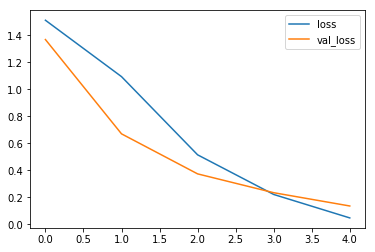

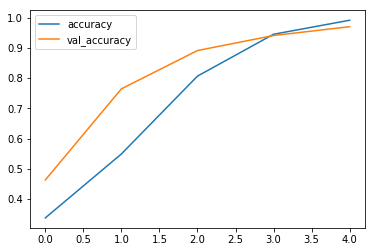

In [18]:
# 绘制模型训练过程曲线
plot_training_history(history)


+ 加载模型和模型评估


In [19]:
def load_and_model_prediction(val_X, val_y, model_path = 'results/demo.h5'):
    """
    加载模型和模型评估，打印验证集的 loss 和准确度
    :param validation_generator: 预测数据
    :return: 
    """
    # 加载模型
    model = K.models.load_model(model_path)
    # 获取验证集的 loss 和 accuracy
    loss, accuracy = model.evaluate(val_X, val_y)
    print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy * 100))

In [20]:
load_and_model_prediction(val_X, val_y)

80/80 [==============================] - 2s 24ms/step - loss: 0.1348 - accuracy: 0.9704

Loss: 0.13, Accuracy: 97.04%


In [ ]:
# 导入相关包
import os
import numpy as np
import jieba as jb
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# ------------------------------------------------------------------------------
# 本 cell 代码仅为 Notebook 训练模型结果进行平台测试代码示范
# 可以实现个人数据处理的方式，平台测试通过即可提交代码
#  -----------------------------------------------------------------------------

def load_data(path):
    """
    读取数据和标签
    :param path:数据集文件夹路径
    :return:返回读取的片段和对应的标签
    """
    sentences = []  # 片段
    target = []  # 作者

    # 定义lebel到数字的映射关系
    labels = {'LX': 0, 'MY': 1, 'QZS': 2, 'WXB': 3, 'ZAL': 4}

    files = os.listdir(path)
    for file in files:
        if not os.path.isdir(file):
            f = open(path + "/" + file, 'r', encoding='UTF-8');  # 打开文件
            for line in f.readlines():
                sentences.append(line)
                target.append(labels[file[:-4]])

    target = np.array(target)
    encoder = LabelEncoder()
    encoder.fit(target)
    encoded_target = encoder.transform(target)
    dummy_target = to_categorical(encoded_target)

    return sentences, dummy_target


def padding(text_processed, path, max_sequence_length=80):
    """
    数据处理，如果使用 lstm，则可以接收不同长度的序列。
    :text_processed：不定长的 Token 化文本序列，二维list
    :path：数据集路径
    :max_sequence_length：padding 大小，长句截断短句补 0
    :return 处理后的序列，numpy 格式的二维数组
    """
    res = []
    for text in text_processed:
        if len(text) > max_sequence_length:
            text = text[:max_sequence_length]
        else:
            text = text + [0 for i in range(max_sequence_length - len(text))]
        res.append(text)
    return np.array(res)


path = "./dataset/"
sentences, target = load_data(path)
max_sequence_length = 80
# 使用jieba机精确模式分词
sentences = [".".join(jb.cut(t, cut_all=False)) for t in sentences]
vocab_processor = tf.keras.preprocessing.text.Tokenizer(num_words=60000, oov_token='<UNK>')
vocab_processor.fit_on_texts(sentences)
text_processed = vocab_processor.texts_to_sequences(sentences)
# 将句子padding为固定长度，如果使用lstm则不需要padding为固定长度
text_processed = padding(text_processed, path)

===========================================  **模型预测代码答题区域**  =========================================== 

在下方的代码块中编写 **模型预测** 部分的代码，请勿在别的位置作答

In [ ]:
# -------------------------- 请加载您最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 demo.h5 模型，则 model_path = 'results/demo.h5'
model_path = None

# 加载模型，如果采用 keras 框架训练模型，则 model=load_model(model_path)
model = load_model(model_path)

# ---------------------- 模型预测，注意不要修改函数的输入输出 -------------------------
def predict(text):
    """
    :param text: 中文字符串
    :return: 字符串格式的作者名缩写，比如:'LX'
    """
    # ----------- 实现预测部分的代码，以下样例可代码自行删除，实现自己的处理方式 -----------
    
    labels = {0: 'LX', 1: 'MY', 2: 'QZS', 3: 'WXB', 4: 'ZAL'}
    sen_prosessed = " ".join(jb.cut(text, cut_all=True))
    max_sequence_length = 80
    sen_prosessed = vocab_processor.texts_to_sequences([sen_prosessed])[0]
    if len(sen_prosessed) > max_sequence_length:
        sen_prosessed = sen_prosessed[:max_sequence_length]
    else:
        sen_prosessed += [0 for _ in range(max_sequence_length - len(sen_prosessed))]
    sen_prosessed = np.array(sen_prosessed).reshape(1, -1)
    
    # 加载模型进行预测
    result = model.predict(sen_prosessed)
    prediction = labels[list(result[0]).index(max(result[0]))]
    # --------------------------------------------------------------------------

    return prediction

In [ ]:
sen = "我听到一声尖叫，感觉到蹄爪戳在了一个富有弹性的东西上。定睛一看，不由怒火中烧。原来，趁着我不在，隔壁那个野杂种——沂蒙山猪刁小三，正舒坦地趴在我的绣榻上睡觉。我的身体顿时痒了起来，我的目光顿时凶了起来。"
predict(sen)